In [2]:
import spacy
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
import matplotlib as mpl
from collections import Counter, defaultdict
import math

In [3]:
def get_adjective_phrases(text) -> list:
    def get_to_object(token) -> int:
        for child in token.children:
            subtoken = list(child.children)
            subtoken = [token for token in subtoken if token.dep_ == 'prep']
            if (child.pos_ in ['NOUN', 'PRON', 'PROPN']) and (child.dep_ == 'pobj'):
                return child.i
            elif (len(subtoken) > 0):
                    test_arr = [get_to_object(text) for text in subtoken]
                    if (len(test_arr) > 0):
                        test_arr[0]
    doc = nlp(text)
    phrases = []
    for token in doc:
        phrase = ''
        if (token.pos_ == 'ADJ') and (token.dep_ in ['ROOT', 'acomp', 'amod', 'conj']):
            phrase += token.text
            adjective_position = token.i
            for subtoken in token.children:
				# first rule: if there is an adverb that modifies the adjective
				# we add it to the phrase in front of the adjective
                if (subtoken.pos_ == 'ADV') and (subtoken.dep_ == 'advmod'):
                    phrase = subtoken.text + ' ' + phrase
				# second rule: if there is a preposition - indicating that
				# there is an object that gives us more info about the prep
				# we add all tokens up until the noun
                if (subtoken.pos_ in ['ADP', 'SCONJ']) and (subtoken.dep_ == 'prep'):
                    try:
                        noun_position = get_to_object(subtoken)
                        for i in range(adjective_position + 1, noun_position + 1):
                            phrase += ' ' + doc[i].text
                    except TypeError:
                        pass
        elif (token.pos_ == 'ADV') and (token.dep_ == 'advmod'):
            phrase += token.text
            adverb_position = token.i
            for subtoken in token.children:
				# first rule: if there is an adverb that modifies the adjective
				# we add it to the phrase in front of the adjective
                if (subtoken.pos_ == 'ADJ') and (subtoken.dep_ in ['ROOT', 'acomp', 'amod', 'advmod']):
                    phrase = subtoken.text + ' ' + phrase
				# second rule: if there is a preposition - indicating that
				# there is an object that gives us more info about the prep
				# we add all tokens up until the noun
        
        elif (token.pos_ == 'AUX') and (token.dep_ == 'ROOT'):
            # case where adjective and adverb are both child nodes
            adv = adj =  None
            for subtoken in token.children:
                if subtoken.dep_ == 'advmod':
                    if adv == None:
                        adv = subtoken
                if subtoken.dep_ == 'acomp':
                    if adj == None:
                        adj = subtoken
                if adv != None and adj != None:
                    if adv.i +1 == adj.i:
                        phrase = adv.text + " " + adj.text
		# since it is a phrase, it needs to have more than one word
		# i.e. a lone adjective does not constitute an adjective phrase
        if len(phrase.split()) > 1:
            phrases.append(phrase)
    return phrases

In [4]:
nlp = spacy.load("en_core_web_sm")

In [5]:
reviews = pd.read_json('../data/reviewSelected100.json', encoding='ISO-8859-1', lines=True)

A sample of what we get from real life data

In [6]:
# get reviews for a random business
random_business = reviews.sample(random_state=42)
random_business_id = random_business.iloc[0]['business_id']
small_business_dataset = reviews.loc[reviews['business_id'] == random_business_id]
small_business_dataset.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
11200,wysFaMq5S88mF6HLxdh3Vw,4nQ7MOkbc5u-DYUOgjiDsg,yEZn1XpLsEC9uBa-X4xAZw,4,1,0,0,Cute little vietnamese sandwich place on St De...,2016-03-17 14:29:44
11204,z81YK3CXQJb48BU7ZAcf7A,Ht8iGitRu8kynEubcIhsTQ,yEZn1XpLsEC9uBa-X4xAZw,4,7,2,8,"Hey Hey, it's the SAMMIES!\n\nSuper Yummy here...",2011-11-30 03:26:01
11209,tqajcnZA97HlXkIYrdNVlg,-a0XgJCXoJln2Ue_JMnfIQ,yEZn1XpLsEC9uBa-X4xAZw,3,0,0,0,Sandwich was good but service was terrible. We...,2016-07-14 18:52:34
11212,wXz1c5kz0QB2nvZVTnnkIg,F9ivL7-mzKbfnLO1rKUFFQ,yEZn1XpLsEC9uBa-X4xAZw,5,0,0,0,"Super fresh, delicious and cheap Banh Mi in th...",2017-07-28 17:48:01
11258,89J69mHgTTF25Ln97ONTrQ,La1ggB37gvq6UWpEWaMtMA,yEZn1XpLsEC9uBa-X4xAZw,4,2,0,2,Que ce soit pour leurs délicieux bubbles tea/s...,2012-12-04 21:25:13


In [7]:
small_business_dataset_reviews = list(small_business_dataset['text'])
# lowercase and correct the text
# this probably works but it takes too long to run so just run this when we want to submit it
# small_business_dataset_reviews = [TextBlob(text).correct() for text in small_business_dataset_reviews]
small_business_dataset_reviews = [sent_tokenize(text) for text in small_business_dataset_reviews]
small_business_dataset_reviews = [item for sublist in small_business_dataset_reviews for item in sublist]

In [8]:
small_business_phrases = [get_adjective_phrases(text.lower()) for text in small_business_dataset_reviews]
small_business_phrases = [array for array in small_business_phrases if len(array) > 0]
small_business_phrases = [text for sublist in small_business_phrases for text in sublist]
small_business_phrases

['really big',
 'very reasonable',
 'here super yummy',
 'really good',
 'sassy with me',
 'very clear from the start',
 'super fresh',
 'so good',
 'so fresh',
 'perfect for a quick bite',
 'so good',
 'so cheap',
 'cheaper than subway',
 'so good',
 'quite hungry',
 'very little',
 'too way sweet',
 'as just good',
 'sous vos yeux',
 'clairement , on mange',
 'quite crowded',
 'addicted to them',
 'how delicious',
 'tired of greasy cardboard pizza',
 'so addictive',
 'really disappointing',
 'very sad about my sandwich',
 'tremendously tasty',
 'so good',
 'good for packed lunches',
 'pretty cheap to boot',
 'quite cheap',
 'too cheap',
 'too lazy',
 'very healthy',
 'better than subway',
 'hard pressed',
 'as good',
 'as almost cheap',
 'how friendly',
 'as good',
 'milky iced',
 'slightly pricier',
 'pretty small',
 'really excited',
 'so terrible',
 'soft on the inside',
 'very reasonable',
 'quite tasty',
 'very tender',
 'too many',
 'already pre',
 'cloyingly sweet',
 'complete

In [9]:
phrase_counts = Counter(small_business_phrases)
freq_phrases = phrase_counts.most_common(10)
freq_phrases


[('so good', 8),
 ('very good', 5),
 ('as good', 3),
 ('very reasonable', 2),
 ('super fresh', 2),
 ('hard pressed', 2),
 ('soft on the inside', 2),
 ('just average', 2),
 ('quite good', 2),
 ('so much', 2)]

## Doing it for all of the data that we have

In [10]:
reviews

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,8aoJJdKEO3ypoZNszpPu7Q,bGgAL09pxLnV_FFgR4ZADg,ZBE-H_aUlicix_9vUGQPIQ,5,0,0,0,We had my Mother's Birthday Party here on 10/2...,2016-11-09 20:07:25
1,J5NOCLdhuhor7USRhtYZ8w,pFCb-1j6oI3TDjr26h2cJQ,e-YnECeZNt8ngm0tu4X9mQ,4,0,0,0,Good Korean grill near Eaton Centre. The marin...,2015-12-05 05:06:43
2,PXiLWAYRt3xnHaJ8MB4rzw,mEzc6LeTNiQgIVsq3poMbg,j7HO1YeMQGYo3KibMXZ5vg,5,2,1,3,Was recommended to try this place by few peopl...,2014-10-11 05:16:15
3,VrLarvxZYJm74yAqtpe9PQ,o-zUN2WEZgjQS7jnNsec0g,7e3PZzUpG5FYOTGt3O3ePA,3,0,0,0,Ambience: Would not expect something this nice...,2016-07-25 03:45:26
4,C1CUpidlVFprUCkApqzCmA,Wlx0iBXJvk4x0EeOt2Bz1Q,vuHzLZ7nAeT-EiecOkS5Og,1,11,0,3,Absolutely the WORST pool company that I have ...,2016-04-11 18:49:11
...,...,...,...,...,...,...,...,...,...
15295,qknwFVEh_0KSuexigYBI_A,YMGmyPOU65SMs4H60ltYiw,shIPnFoXrL3dFo5HLH1_HA,1,2,0,0,This was the worst experience ever. So much so...,2014-07-12 21:58:15
15296,Y-ZRoyAXCukBK1uK1ZcZCA,JLhOWQiWtGbr14K_KmoWxA,zPEYgVqJ2QNKi45FJi2jvg,5,0,0,0,We come here every time we hit Vegas! A giant ...,2018-11-10 21:38:49
15297,A8HdjBfhj3pgQuSbwNtDEw,6CoiKFDFXIACJZvv_I_8mQ,zPEYgVqJ2QNKi45FJi2jvg,1,0,1,0,As locals we used to the this place when it w...,2018-10-13 22:11:22
15298,2n1QdrYBRAAe6GKaxEV0jA,_fH4s3ls08eSl_PfX38KIA,etzDsNjkCyQBoJcU2a3U-g,5,0,0,0,The food was delicious. We were seated in 15 m...,2015-02-15 08:43:46


In [11]:
reviews_list = reviews[['business_id', 'text']]
reviews_list = reviews_list.groupby(['business_id'])['text'].apply(','.join).reset_index()
reviews_list

,business_id,text
0,--I7YYLada0tSLkORTHb5Q,"Had to get my wing fix, I like dry rubs on win..."
1,-7XWJYkutqhIxLen7Grg1g,Definite recommend. \n\nBut I never would have...
2,0Rni7ocMC_Lg2UH0lDeKMQ,We love Barros!! Usually go to other locations...
3,0kPm1zEpeXFRg8D2phqgCQ,"Coffee is exponentially better than Starbucks,..."
4,1Fpk8ibHhZYnCw8fnGny8w,Really love the food here! I was a HUGE fan of...
...,...,...
148,yHHVKa9joZAKiBDUp2SkKw,"This coffee shop has great coffee, but more im..."
149,z8Em-bhZI3Mmspml7tj6tg,This was the first time and probably the last ...
150,zPEYgVqJ2QNKi45FJi2jvg,Stopped by here for lunch yesterday. What a d...
151,zZ7KDK3GAkBUZzsaqB1A4Q,"Staff is SO friendly, I was checked in on once..."


In [12]:
# reviews_dict: list of dicts, one for each business
reviews_dict = reviews_list.to_dict('records')

In [13]:
#trial code
reviews_test = reviews_dict[:2]
test = [get_adjective_phrases(review['text']) for review in reviews_test]
test[0]

['always good',
 'Just average',
 'also fantastic',
 'least once',
 'how good',
 'how delicious',
 'very pleased',
 'very good',
 'very friendly',
 'really good',
 'very prompt',
 'real good',
 'too much',
 'Very good',
 'pretty decent',
 'pretty good',
 'most recent',
 'pretty average',
 'way friendlier to the other tables',
 'exceptionally good',
 'very empty',
 'careful with the add - ons',
 'better than many other places',
 'enough large',
 'barely hot',
 'extremely attentive',
 'very busy',
 'Too many',
 'super busy',
 'really nice',
 'very friendly',
 'so excited',
 'too low',
 'pleased with the food',
 'frustrated with the service',
 'pleased with the ribs',
 'very good',
 'very good',
 'much better than our first experience',
 'very friendly',
 'very nice',
 'pretty good',
 'very good',
 'Otherwise happy',
 'too busy',
 'how busy',
 'just wonderful',
 'pretty awesome',
 'ridiculously good',
 'just sad',
 'very spacious',
 'all exceptional',
 'very reasonable',
 'very marginal',

In [14]:
# this cell will take some time to run
phrases_dict = [get_adjective_phrases(review['text']) for review in reviews_dict]

In [15]:
phrases_dict

[['always good',
  'Just average',
  'also fantastic',
  'least once',
  'how good',
  'how delicious',
  'very pleased',
  'very good',
  'very friendly',
  'really good',
  'very prompt',
  'real good',
  'too much',
  'Very good',
  'pretty decent',
  'pretty good',
  'most recent',
  'pretty average',
  'way friendlier to the other tables',
  'exceptionally good',
  'very empty',
  'careful with the add - ons',
  'better than many other places',
  'enough large',
  'barely hot',
  'extremely attentive',
  'very busy',
  'Too many',
  'super busy',
  'really nice',
  'very friendly',
  'so excited',
  'too low',
  'pleased with the food',
  'frustrated with the service',
  'pleased with the ribs',
  'very good',
  'very good',
  'much better than our first experience',
  'very friendly',
  'very nice',
  'pretty good',
  'very good',
  'Otherwise happy',
  'too busy',
  'how busy',
  'just wonderful',
  'pretty awesome',
  'ridiculously good',
  'just sad',
  'very spacious',
  'all

In [16]:
phrases_dict_a = [Counter(phrase_list) for phrase_list in phrases_dict]

we can then get the most common phrases. this is where the fun begins

In [17]:
most_common_phrases = [counter.most_common(5) for counter in phrases_dict_a]
most_common_phrases

[[('pretty good', 9),
  ('very good', 7),
  ('really good', 7),
  ('very friendly', 4),
  ('very busy', 3)],
 [('so good', 6),
  ('very nice', 4),
  ('very fresh', 4),
  ('extremely fresh', 3),
  ('really good', 3)],
 [('pretty good', 5),
  ('really good', 3),
  ('as good', 3),
  ('pretty tasty', 2),
  ('very nice', 2)],
 [('very clean', 3),
  ('very friendly', 3),
  ('very good', 2),
  ('really good', 2),
  ('exponentially better than Starbucks', 1)],
 [('very good', 5),
  ('really good', 4),
  ('very attentive', 4),
  ('very tasty', 4),
  ('really busy', 3)],
 [('pretty good', 4),
  ('really nice', 4),
  ('really good', 3),
  ('too crowded', 3),
  ('nearly empty', 3)],
 [('very thorough', 2),
  ('even worse', 2),
  ('very friendly', 2),
  ('very bad', 2),
  ('so many', 2)],
 [('very relaxing', 6),
  ('very professional', 4),
  ('very good', 4),
  ('very friendly', 4),
  ('absolutely amazing', 3)],
 [('pretty good', 6),
  ('really good', 5),
  ('very good', 4),
  ('so many', 3),
  ('t

since this does not show any good results as they are not indicative of anything, we look into TF-IDF

In [18]:
# get the most common phrases from all the datasets
all_phrases = dict(sum(phrases_dict_a, Counter()))
all_phrases

{'always good': 35,
 'Just average': 2,
 'also fantastic': 5,
 'least once': 55,
 'how good': 42,
 'how delicious': 11,
 'very pleased': 14,
 'very good': 545,
 'very friendly': 319,
 'really good': 407,
 'very prompt': 4,
 'real good': 6,
 'too much': 110,
 'Very good': 34,
 'pretty decent': 49,
 'pretty good': 403,
 'most recent': 34,
 'pretty average': 6,
 'way friendlier to the other tables': 1,
 'exceptionally good': 4,
 'very empty': 2,
 'careful with the add - ons': 1,
 'better than many other places': 1,
 'enough large': 8,
 'barely hot': 2,
 'extremely attentive': 7,
 'very busy': 68,
 'Too many': 12,
 'super busy': 30,
 'really nice': 117,
 'so excited': 37,
 'too low': 2,
 'pleased with the food': 4,
 'frustrated with the service': 1,
 'pleased with the ribs': 1,
 'much better than our first experience': 1,
 'very nice': 326,
 'Otherwise happy': 1,
 'too busy': 63,
 'how busy': 32,
 'just wonderful': 5,
 'pretty awesome': 16,
 'ridiculously good': 4,
 'just sad': 4,
 'very s

In [19]:
common_phrases_list = [counter.most_common() for counter in phrases_dict_a]
common_phrases = [tuples for sublist in common_phrases_list for tuples in sublist]
common_phrases

[('pretty good', 9),
 ('very good', 7),
 ('really good', 7),
 ('very friendly', 4),
 ('very busy', 3),
 ('too much', 2),
 ('too busy', 2),
 ('very spacious', 2),
 ('just ok', 2),
 ('very attentive', 2),
 ('super friendly', 2),
 ('always good', 1),
 ('Just average', 1),
 ('also fantastic', 1),
 ('least once', 1),
 ('how good', 1),
 ('how delicious', 1),
 ('very pleased', 1),
 ('very prompt', 1),
 ('real good', 1),
 ('Very good', 1),
 ('pretty decent', 1),
 ('most recent', 1),
 ('pretty average', 1),
 ('way friendlier to the other tables', 1),
 ('exceptionally good', 1),
 ('very empty', 1),
 ('careful with the add - ons', 1),
 ('better than many other places', 1),
 ('enough large', 1),
 ('barely hot', 1),
 ('extremely attentive', 1),
 ('Too many', 1),
 ('super busy', 1),
 ('really nice', 1),
 ('so excited', 1),
 ('too low', 1),
 ('pleased with the food', 1),
 ('frustrated with the service', 1),
 ('pleased with the ribs', 1),
 ('much better than our first experience', 1),
 ('very nice', 1

In [20]:
DF = {}
for i, phrase_tuple in enumerate(common_phrases):
    phrase: str = phrase_tuple[0]
    try:
        DF[phrase].add(i)
    except:
        DF[phrase] = {i}

In [21]:
# count across the entire document
for i in DF:
    DF[i] = len(DF[i])
DF

{'pretty good': 117,
 'very good': 129,
 'really good': 126,
 'very friendly': 117,
 'very busy': 45,
 'too much': 69,
 'too busy': 45,
 'very spacious': 10,
 'just ok': 44,
 'very attentive': 52,
 'super friendly': 77,
 'always good': 29,
 'Just average': 2,
 'also fantastic': 5,
 'least once': 41,
 'how good': 33,
 'how delicious': 10,
 'very pleased': 14,
 'very prompt': 4,
 'real good': 6,
 'Very good': 31,
 'pretty decent': 38,
 'most recent': 28,
 'pretty average': 5,
 'way friendlier to the other tables': 1,
 'exceptionally good': 4,
 'very empty': 2,
 'careful with the add - ons': 1,
 'better than many other places': 1,
 'enough large': 8,
 'barely hot': 2,
 'extremely attentive': 7,
 'Too many': 12,
 'super busy': 23,
 'really nice': 80,
 'so excited': 26,
 'too low': 2,
 'pleased with the food': 4,
 'frustrated with the service': 1,
 'pleased with the ribs': 1,
 'much better than our first experience': 1,
 'very nice': 122,
 'Otherwise happy': 1,
 'how busy': 27,
 'just wonde

In [22]:
total_vocab = [x for x in DF]
print(total_vocab)

['pretty good',
 'very good',
 'really good',
 'very friendly',
 'very busy',
 'too much',
 'too busy',
 'very spacious',
 'just ok',
 'very attentive',
 'super friendly',
 'always good',
 'Just average',
 'also fantastic',
 'least once',
 'how good',
 'how delicious',
 'very pleased',
 'very prompt',
 'real good',
 'Very good',
 'pretty decent',
 'most recent',
 'pretty average',
 'way friendlier to the other tables',
 'exceptionally good',
 'very empty',
 'careful with the add - ons',
 'better than many other places',
 'enough large',
 'barely hot',
 'extremely attentive',
 'Too many',
 'super busy',
 'really nice',
 'so excited',
 'too low',
 'pleased with the food',
 'frustrated with the service',
 'pleased with the ribs',
 'much better than our first experience',
 'very nice',
 'Otherwise happy',
 'how busy',
 'just wonderful',
 'pretty awesome',
 'ridiculously good',
 'just sad',
 'all exceptional',
 'very reasonable',
 'very marginal',
 'pretty empty',
 'happy with the experienc

In [23]:
DocumentTF = []
for i, sublist in enumerate(common_phrases_list):
    TF = defaultdict(int)
    adj_phrase_count: int = 0
    for tuples in sublist:
        adj_phrase_count += tuples[1]
    
    for tuples in sublist:
        TF[tuples[0]] = tuples[1]/adj_phrase_count
    DocumentTF.append(TF)

In [24]:
def computeIDF(word: str) -> float:
    N = len(common_phrases_list)
    num_review = 0
    for reviews in common_phrases_list:
        for review_tuples in reviews:
            if word == review_tuples[0]:
                num_review += 1
    return math.log(N / float(num_review))

In [25]:
temp_idf_dict = defaultdict(int)
for word in total_vocab:
    temp_idf_dict[word] = computeIDF(word)
# idf_list = [{word: computeIDF(word)} for word in total_vocab]

In [26]:
DocumentTF[0].keys()

dict_keys(['pretty good', 'very good', 'really good', 'very friendly', 'very busy', 'too much', 'too busy', 'very spacious', 'just ok', 'very attentive', 'super friendly', 'always good', 'Just average', 'also fantastic', 'least once', 'how good', 'how delicious', 'very pleased', 'very prompt', 'real good', 'Very good', 'pretty decent', 'most recent', 'pretty average', 'way friendlier to the other tables', 'exceptionally good', 'very empty', 'careful with the add - ons', 'better than many other places', 'enough large', 'barely hot', 'extremely attentive', 'Too many', 'super busy', 'really nice', 'so excited', 'too low', 'pleased with the food', 'frustrated with the service', 'pleased with the ribs', 'much better than our first experience', 'very nice', 'Otherwise happy', 'how busy', 'just wonderful', 'pretty awesome', 'ridiculously good', 'just sad', 'all exceptional', 'very reasonable', 'very marginal', 'pretty empty', 'happy with the experience', 'always friendly', 'decent(not worth',

In [27]:
DocumentTF[0]['very good']

0.045454545454545456

In [28]:
temp_idf_dict['very good']

0.17062551703076345

In [29]:
def computeTFIDF(TF, idf_list):
    TFIDF = defaultdict(float)
    for phrase in TF.keys():
        phrase_tf_idf = TF[phrase] * idf_list[phrase]
        TFIDF[phrase] = phrase_tf_idf
    return TFIDF

In [30]:
TFIDFList = [computeTFIDF(TF, temp_idf_dict) for TF in DocumentTF]

In [31]:
TFIDFList[0]

defaultdict(float,
            {'pretty good': 0.015677765450338405,
             'very good': 0.007755705319580157,
             'really good': 0.008825273383679883,
             'very friendly': 0.006967895755705958,
             'very busy': 0.023839781135495758,
             'too much': 0.010341966451885405,
             'too busy': 0.01589318742366384,
             'very spacious': 0.03542666010907,
             'just ok': 0.016185042694469798,
             'very attentive': 0.014015509127415691,
             'super friendly': 0.008917305188814957,
             'always good': 0.01079962397016858,
             'Just average': 0.028164225589821366,
             'also fantastic': 0.022214285772456724,
             'least once': 0.008551076978494337,
             'how good': 0.009960586752765944,
             'how delicious': 0.017713330054535,
             'very pleased': 0.0155284454011505,
             'very prompt': 0.023663269871899643,
             'real good': 0.021030379559508

In [32]:
max_0 = max(TFIDFList[0], key=TFIDFList[0].get)

In [33]:
max_0

'very spacious'

### Cloud tries in jeth.ipynb

In [34]:
import gensim
from gensim import models
from gensim.models import Word2Vec, KeyedVectors

from gensim.models import Phrases
# Train a bigram detector.
bigram_transformer = Phrases(small_business_phrases)
# remove duplicates
common_phrases_list1 = []
for i in common_phrases_list:
    for j in i:
        common_phrases_list1.append(j[0])
common_phrases_list1 = set(common_phrases_list1)
common_phrases_list1 = list(common_phrases_list1)
# Apply the trained MWE detector to a corpus, using the result to train a Word2vec model.
model = Word2Vec([common_phrases_list1], min_count=1)

In [35]:
import random
random_word = random.choice(model.wv.index_to_key)

In [36]:
random_word

'SO friendly'

In [37]:
model.wv.most_similar('consistently delicious')[:5]

[('pleased with the wide range', 0.3919488489627838),
 ('more standard', 0.3790111839771271),
 ('pretty limited', 0.3588227927684784),
 ('exceedingly kind', 0.35517704486846924),
 ('actually available', 0.34226977825164795)]

In [38]:
rare_phrase = []
for i in common_phrases_list1:
    j = model.wv.most_similar(i)[0][1]
    if j < 0.30:
        rare_phrase.append(i)
rare_phrase

[]

### claudia_tried, claudia_gave_up
### jeth_continues

In [39]:
X = model[model.wv.vocab]
print(gensim.__version__)

AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

# going to try sklearn here

In [ ]:
from sklearn import cluster
from sklearn import metrics
for n_clusters in range(20):
    kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
    preds = kmeans.fit_predict(X)
    centers = kmeans.cluster_centers_
    
    score = metrics.silhouette_score(X, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

# now it's nltk

In [ ]:
from nltk.cluster import KMeansClusterer
import nltk
NUM_CLUSTERS=3
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
print (assigned_clusters)

[0, 1, 1, 0, 2, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 0, 1, 2, 2, 1, 1, 2, 1, 0, 2, 0, 2, 1, 0, 2, 2, 1, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 0, 1, 0, 0, 1, 2, 2, 1, 1, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 1, 2, 2, 0, 2, 0, 0, 1, 0, 0, 1, 2, 2, 0, 0, 1, 1, 2, 0, 0, 0, 2, 1, 0, 0, 1, 2, 1, 0, 2, 1, 0, 0, 1, 0, 2, 2, 2, 1, 2, 1, 0, 0, 0, 2, 1, 2, 2, 1, 1, 0, 0, 1, 2, 0, 2, 1, 2, 2, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 2, 1, 0, 0, 2, 1, 1, 1, 0, 0, 2, 2, 1, 2, 1, 1, 1, 0, 0, 2, 2, 0, 2, 2, 1, 0, 2, 2, 2, 0, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 2, 1, 0, 0, 1, 2, 0, 1, 0, 1, 2, 1, 1, 0, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 2, 1, 2, 0, 2, 1, 2, 0, 0, 0, 0, 1, 0, 1, 1, 2, 1, 0, 0, 1, 1, 1, 0, 2, 2, 1, 2, 1, 2, 0, 0, 1, 1, 2, 0, 2, 1, 2, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 1, 1, 1, 2, 0, 0, 1, 2, 0, 2, 2, 2, 1, 1, 2, 0, 2, 0, 0, 2, 0, 1, 1, 0, 0, 2, 2, 2, 1, 1, 0, 0, 0, 2, 0, 2, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 0, 1, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 2, 2, 0, 2, 1, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 1, 0, 2, 

In [ ]:
words = list(model.wv.vocab)
for i, word in enumerate(words):  
    print (word + ":" + str(assigned_clusters[i]))

most impressive:0
incredibly odd:1
pretty romantic:1
incredibly awful:0
almost non almost non almost non almost non almost non almost non :2
more visited:1
absolutely solid:1
extremely tough:1
so instant:2
really good:0
so undercooked:1
so lame:1
so worried:1
really cold:2
so cute:1
very classy:2
so average:1
actually gross actually gross :2
very sad:1
all delicious all delicious all delicious :1
always bad always bad always bad :1
most genuine:2
too separate:0
so careful:1
completely horrendous:2
really really disappointed:2
whatsoever pushy:1
also friendly also friendly also friendly also friendly :1
of rough:2
very fast:1
very convenient:0
exceptionally meh:2
that great:0
extremely unwelcome:2
well informed:1
too way spicy:0
around horrible:2
incredibly loud:2
insanely confusing:1
more inconvenient:0
enough hungry:0
quite negative:0
pretty prompt:0
pretty huge:1
far unacceptable:1
particularly authentic:1
so passionate:2
back numerous:2
enough clear:2
terribly inconsistent:2
fiery h

## tim tries fasttext baby

In [55]:
from pprint import pprint as print
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath

<AxesSubplot:xlabel='0', ylabel='1'>

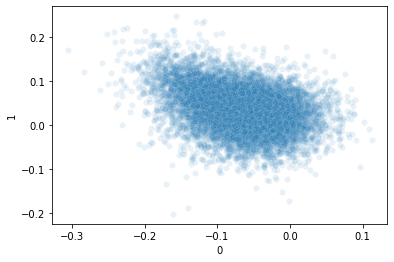

In [56]:
# create 2d fasttext model, piggyback on cloud/jeth code
model = FastText([common_phrases_list1], min_count=1, vector_size=2)

# plot vectors??
vectors = {phrase: model.wv[phrase] for phrase in common_phrases_list1}
df = pd.DataFrame(vectors).transpose()
import seaborn as sns
sns.scatterplot(data=df, x=0, y=1, alpha=0.1)

In [57]:
# create proper model, piggyback on cloud/jeth code
model = FastText([common_phrases_list1], min_count=1)

In [58]:
model.wv.most_similar('too bad')[:5]

[('all too bad', 0.901890218257904),
 ('too so bad', 0.9005563855171204),
 ('too all bad', 0.8791950941085815),
 ('too back bad', 0.8768033385276794),
 ('too entirely much', 0.8670836091041565)]

In [ ]:
X = model.wv.index_to_key
print(X[:5])

['absolutely glowing',
 'just fine',
 'just unfortunate',
 'really delicious',
 'very surprised they deliver this far and especially with the 1hr ordering']


In [64]:
# clustering time baby
from sklearn import cluster
from sklearn import metrics

X = [model.wv[phrase] for phrase in common_phrases_list1]

sil_score = {}

for n_clusters in range(2, 20):
    kmeans = cluster.KMeans(n_clusters=n_clusters)
    preds = kmeans.fit_predict(X)
    centers = kmeans.cluster_centers_
    
    score = metrics.silhouette_score(X, preds)
    sil_score[n_clusters] = score
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

'For n_clusters = 2, silhouette score is 0.4173874258995056)'
'For n_clusters = 3, silhouette score is 0.2508279085159302)'
'For n_clusters = 4, silhouette score is 0.18059056997299194)'
'For n_clusters = 5, silhouette score is 0.14730137586593628)'
'For n_clusters = 6, silhouette score is 0.1110435500741005)'
'For n_clusters = 7, silhouette score is 0.09097591042518616)'
'For n_clusters = 8, silhouette score is 0.07570511102676392)'
'For n_clusters = 9, silhouette score is 0.062215764075517654)'
'For n_clusters = 10, silhouette score is 0.0526454858481884)'
'For n_clusters = 11, silhouette score is 0.043748609721660614)'
'For n_clusters = 12, silhouette score is 0.054716914892196655)'
'For n_clusters = 13, silhouette score is 0.04043689742684364)'
'For n_clusters = 14, silhouette score is 0.04189607501029968)'
'For n_clusters = 15, silhouette score is 0.04492645710706711)'
'For n_clusters = 16, silhouette score is 0.040549781173467636)'
'For n_clusters = 17, silhouette score is 0.0371

Text(0, 0.5, 'Silhouette Score')

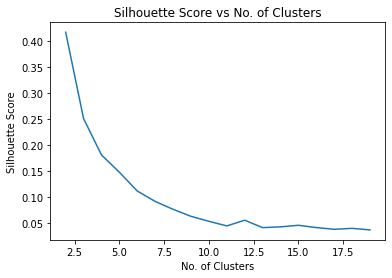

In [72]:
f = sns.lineplot(data=sil_score)
f.set_title("Silhouette Score vs No. of Clusters")
f.set_xlabel("No. of Clusters")
f.set_ylabel("Silhouette Score")


In [73]:
# 2 clusters has the highest score??
from nltk.cluster import KMeansClusterer
import nltk
NUM_CLUSTERS=2
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)